In [24]:
from collections import defaultdict

def indexes(l, chosen_key):
    _indices = defaultdict(list)
    for index, item in enumerate(l):
        _indices[item].append(index)

    for key, value in _indices.items():
        if key == chosen_key:
            return value
#indexes(labels, 0)

21 - Rebeca - Super Noisy, 0.58 accuracy, because the noisy problem is similar in the contiguous labels, that is why Calibration 2 may be a bad idea.

22 - Alma - Looks good

23 - Valeria - Looks good

24 - Alma - Stagnations

25 - Blink_in_between - Stagnations

26 - Blink only in blue - Stagnations

27 - Santiago (Multiplayer calibration) - Stagnations

28 - Eduardo (Multiplayer calibration) - Stagnations

29 - Rebeca - Alone

30 - Rebeca (Multiplayer calibration) with earphones on bluetooth but not using them

31 - Alma (Multiplayer calibration) with earphones on bluetooth but not using them

01 - Alma (Alone Calibration 2) with earphones

In [83]:
from mne import EpochsArray
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from scipy import signal
from autoreject import AutoReject

dataset_name = 'BrainCommand'
dataset_info = {  # BrainCommand
                    'dataset_name': 'BrainCommand',
                    '#_class': 4,
                    "target_names": ['Derecha', 'Izquierda', 'Arriba', 'Abajo'],
                    '#_channels': 8,
                    'samples': 350,  # 250*1.4
                    'sample_rate': 250,
                    'channels_names': ['C4', 'FC3', 'F5', 'C3', 'F7', 'Cz', 'P3', 'C5'],
                    'subjects': 0,  # PENDING
                    'total_trials': 0,  # VARIABLE SINCE THE SUBJECT HAS TOTAL CONTROL OF HOW MANY MOVEMENTS THEY WANT TO DO
                    }

def data_normalization(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def remove_too_different_trials_v2(data: np.array, label) -> np.array:
    data_cleaned = []
    label_cleaned = []
    for word_index in range(len(dataset_info["target_names"])):
        indexes_from_word = indexes(label, word_index)
        for i_index in indexes_from_word:
            trial = data[i_index,:,:]
            trial_label = label[i_index]
            if np.mean(np.abs(trial)) < np.mean(np.abs(data[indexes_from_word,:,:]))*1.5 :
                data_cleaned.append(trial)
                label_cleaned.append(trial_label)
    return np.array(data_cleaned), label_cleaned

def remove_too_different_trials_v1(data: np.array, label) -> np.array: #todo: decide which one is better when you get more data
    average_of_trials: int = np.mean(np.abs(data))
    data_cleaned = []
    label_cleaned = []
    for trial, trial_label in zip(data, label):
        if np.mean(np.abs(trial)) < average_of_trials*1.5 :
            data_cleaned.append(trial)
            label_cleaned.append(trial_label)
    return np.array(data_cleaned), label_cleaned

def convert_to_epochs(data, labels):
    events = np.column_stack((
        np.arange(0, dataset_info['sample_rate'] * data.shape[0], dataset_info['sample_rate']),
        np.zeros(len(labels), dtype=int),
        np.array(labels),
    ))

    event_dict = {'Arriba': 2, 'Abajo': 3, 'Derecha': 0, 'Izquierda': 1}

    epochs = EpochsArray(data, info=mne.create_info(
        sfreq=dataset_info['sample_rate'], ch_types='eeg', ch_names=dataset_info['channels_names']), events=events,
                         event_id=event_dict)
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)

    ar = AutoReject()
    epochs = ar.fit_transform(epochs)
    return epochs.get_data(), epochs.events[:, -1]

def braincommand_dataset_loader(game_mode: str, subject_id: int):
    complete_information = pd.read_csv(f'assets/game_saved_files/eeg_data_{game_mode}_sub{subject_id:02d}.csv')
    x_list = list(complete_information['time'].apply(eval))
    label = list(complete_information['class'][1:])# TODO: I'm removing the first one because the EEG data is incomplete. Real time seems to have this problem too. So the first one will always be lost

    label_0 = label.count(0)
    print(f"label 0 is {label_0}")

    label_1 = label.count(1)
    print(f"label 1 is {label_1}")

    label_2 = label.count(2)
    print(f"label 2 is {label_2}")

    label_3 = label.count(3)
    print(f"label 3 is {label_3}")

    x_array = np.array(x_list[1:]) # trials, time, channels
    x_array = x_array[:, :, :-9] # The last channels are accelerometer (x3), gyroscope (x3), validity, battery and counter
    x_array = np.transpose(x_array, (0, 2, 1))
    x_array = signal.detrend(x_array)
    #x_array, label = convert_to_epochs(x_array, label)
    x_array = data_normalization(x_array)
    return x_array, label


subject_id = 3
game_mode = 'calibration2'
event_dict = {'Arriba': 2, 'Abajo': 3, 'Derecha': 0,'Izquierda': 1}

data, labels = braincommand_dataset_loader(game_mode, subject_id)


events = np.column_stack((
    np.arange(0, dataset_info['sample_rate'] * data.shape[0], dataset_info['sample_rate']),
    np.zeros(len(labels), dtype=int),
    np.array(labels),
))

epochs = EpochsArray(data, info=mne.create_info(
                        sfreq=dataset_info['sample_rate'], ch_types='eeg', ch_names=dataset_info['channels_names']), events=events,
                     event_id=event_dict)
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

label 0 is 12
label 1 is 11
label 2 is 12
label 3 is 10
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated


Number of events,45
Events,Abajo: 10Arriba: 12Derecha: 12Izquierda: 11
Time range,0.000 – 1.396 s
Baseline,off


In [84]:
len(labels)

45

In [85]:
#epochs.plot(block=True)

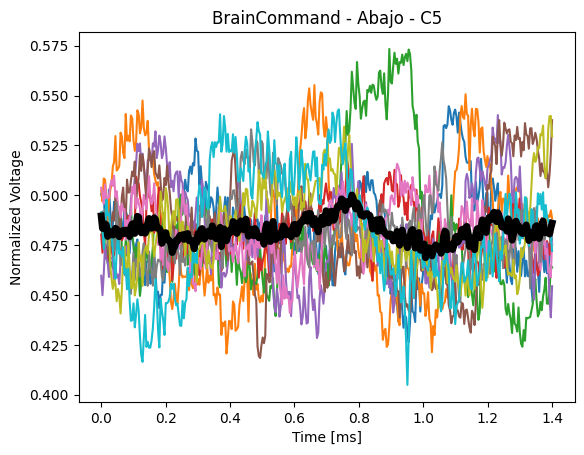

In [86]:
samples_to_time = np.linspace(0, dataset_info["samples"]/dataset_info["sample_rate"], num=dataset_info["samples"])
for channel in range(len(dataset_info["channels_names"])):
    for word_index in range(len(dataset_info["target_names"])):
        plt.clf()
        indexes_from_word = indexes(labels, word_index)
        for i_index in indexes_from_word:
            plt.plot(samples_to_time, data[i_index,channel,:])
        plt.plot(samples_to_time, np.mean(data[indexes_from_word,channel,:], axis=0), linewidth=5, color='k')
        plt.title(f'{dataset_name} - {dataset_info["target_names"][word_index]} - {dataset_info["channels_names"][channel]}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Normalized Voltage')
        plt.savefig(f'assets/ERP/ERP_{dataset_name}_sub{subject_id:02d}_{dataset_info["target_names"][word_index]}_{dataset_info["channels_names"][channel]}.png')

In [87]:
plt.clf()
plt.plot(samples_to_time,data[100,7,:])

IndexError: index 100 is out of bounds for axis 0 with size 45

<Figure size 640x480 with 0 Axes>

In [ ]:
def identify_flatlines(ts, threshold=0.005): # semi-works.
    for j in range(len(ts)-6):
        if abs(ts[j] - ts[j+3]) <= threshold:
            if abs(ts[j] - ts[j+4]) <= threshold:
                if abs(ts[j] - ts[j+5]) <= threshold:
                    if abs(ts[j] - ts[j+6]) <= threshold:
                        return 1
    else:
        return 0

In [ ]:
identify_flatlines(data[18,7,:])

In [ ]:
count_trials_with_flatlines = []
for trial in range(len(labels)):
    count_trials_with_flatlines.append(identify_flatlines(data[trial,3,:])) # Channel doesnt matter, when the signal stagnates it happens to all of them.
sum(count_trials_with_flatlines)

In [49]:
len(labels)

75

# Do the XDAWN DENOISING HERE AND SEE THE SIGNALS
https://mne.tools/stable/auto_examples/preprocessing/xdawn_denoising.html#sphx-glr-auto-examples-preprocessing-xdawn-denoising-py

In [23]:
# from mne.preprocessing import Xdawn
# from mne.viz import plot_epochs_image
# 
# plot_epochs_image(epochs)
# # Estimates signal covariance
# signal_cov = mne.compute_covariance(epochs)
# 
# # Xdawn instance
# xd = Xdawn(n_components=2, signal_cov=signal_cov)
# 
# # Fit xdawn
# xd.fit(epochs)
# 
# epochs_denoised = xd.apply(epochs)
# 
# # Plot image epoch after Xdawn
# plot_epochs_image(epochs_denoised['Arriba']) # todo: previously you should had made 'picks' and the event dict only dedicated to one event, otherwise it joins eveything